## Import Libraries

In [40]:
import kagglehub
import pandas as pd
import os

## Download Dataset from Kaggle

In [41]:
# path = kagglehub.dataset_download("yeanzc/telco-customer-churn-ibm-dataset")
# files = os.listdir(path)
# print(files)
# print("Path to dataset files:", path)

In [42]:
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

## Read Dataset

In [43]:
#df = pd.read_excel(os.path.join(path, "Telco_customer_churn.xlsx"))

#print(df.head())

print('Columns')
df.columns.to_list()

#print(df.info())

Columns


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

## EDA

## Dataset overview

In [44]:
print("Shape of the DataFrame:", df.shape)
print("\nData types of the columns:")
df.info()

binary_columns = []
categorical_columns = []
numerical_columns = []

for col in df.columns:
    unique_values = df[col].nunique()
    if unique_values == 2:
        binary_columns.append(col)
    elif unique_values > 2 and col != 'customerID':
        categorical_columns.append(col)

# Identify numerical columns
for col in df.columns:
    if col not in binary_columns and col not in categorical_columns and col != 'customerID':
        # Check if the column can be converted to numeric
        if pd.api.types.is_numeric_dtype(df[col]):
             numerical_columns.append(col)
        else:
            # Attempt to convert to numeric, coercing errors
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if pd.api.types.is_numeric_dtype(df[col]):
                 numerical_columns.append(col)
            else:
                # If still not numeric after coercion, consider it categorical
                categorical_columns.append(col)


print("\nBinary columns:", binary_columns)
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

print("\nNumber of unique values in categorical columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()}")

print("\nIrrelevant columns based on name and initial inspection: 'customerID' appears irrelevant for prediction.")

Shape of the DataFrame: (7043, 21)

Data types of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non

## Data quality checks


In [45]:
# 1. Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# 2. Check for empty strings/whitespace in 'TotalCharges'
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for rows where conversion resulted in NaN (originally non-numeric)
non_numeric_totalcharges = df['TotalCharges'].isnull().sum()
print(f"\nNumber of non-numeric entries (including empty strings/whitespace) in 'TotalCharges': {non_numeric_totalcharges}")

# 3. Investigate rows where 'TotalCharges' is not numeric
if non_numeric_totalcharges > 0:
    print("\nRows with non-numeric 'TotalCharges':")
    display(df[df['TotalCharges'].isnull()])

# 4. Check for duplicate 'customerID'
duplicate_customer_ids = df['customerID'].duplicated().sum()
print(f"\nNumber of duplicate 'customerID' entries: {duplicate_customer_ids}")

# 5. Analyze relationship between 'TotalCharges', 'MonthlyCharges', and 'tenure'
# Filter for customers with tenure > 0
df_tenure_positive = df[df['tenure'] > 0].copy()

# Calculate the expected TotalCharges based on MonthlyCharges and tenure
df_tenure_positive['ExpectedTotalCharges'] = df_tenure_positive['MonthlyCharges'] * df_tenure_positive['tenure']

# Calculate the difference between actual and expected TotalCharges
df_tenure_positive['TotalCharges_Difference'] = df_tenure_positive['TotalCharges'] - df_tenure_positive['ExpectedTotalCharges']

# Check for significant differences (e.g., difference greater than a small tolerance)
tolerance = 0.01
inconsistent_charges = df_tenure_positive[abs(df_tenure_positive['TotalCharges_Difference']) > tolerance]

print(f"\nNumber of customers with inconsistent TotalCharges (Actual vs. Monthly * Tenure) for tenure > 0: {len(inconsistent_charges)}")

if len(inconsistent_charges) > 0:
    print("\nExamples of customers with inconsistent TotalCharges:")
    display(inconsistent_charges[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ExpectedTotalCharges', 'TotalCharges_Difference']].head())

# Check if there are any rows where tenure is 0 but TotalCharges is not 0
zero_tenure_non_zero_total = df[(df['tenure'] == 0) & (df['TotalCharges'] != 0)]
print(f"\nNumber of customers with tenure = 0 but TotalCharges != 0: {len(zero_tenure_non_zero_total)}")

if len(zero_tenure_non_zero_total) > 0:
    print("\nExamples of customers with tenure = 0 but TotalCharges != 0:")
    display(zero_tenure_non_zero_total[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']].head())

Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Number of non-numeric entries (including empty strings/whitespace) in 'TotalCharges': 11

Rows with non-numeric 'TotalCharges':


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No



Number of duplicate 'customerID' entries: 0

Number of customers with inconsistent TotalCharges (Actual vs. Monthly * Tenure) for tenure > 0: 6418

Examples of customers with inconsistent TotalCharges:


,customerID,tenure,MonthlyCharges,TotalCharges,ExpectedTotalCharges,TotalCharges_Difference
1,5575-GNVDE,34,56.95,1889.50,1936.3,-46.80
2,3668-QPYBK,2,53.85,108.15,107.7,0.45
3,7795-CFOCW,45,42.30,1840.75,1903.5,-62.75
4,9237-HQITU,2,70.70,151.65,141.4,10.25
5,9305-CDSKC,8,99.65,820.50,797.2,23.30



Number of customers with tenure = 0 but TotalCharges != 0: 11

Examples of customers with tenure = 0 but TotalCharges != 0:


,customerID,tenure,MonthlyCharges,TotalCharges
488,4472-LVYGI,0,52.55,NaN
753,3115-CZMZD,0,20.25,NaN
936,5709-LVOEQ,0,80.85,NaN
1082,4367-NUYAO,0,25.75,NaN
1340,1371-DWPAZ,0,56.05,NaN


## Target variable analysis


In [46]:
churn_counts = df['Churn'].value_counts()
total_customers = len(df)
churn_rate = churn_counts['Yes'] / total_customers

print("Churn Count:")
print(churn_counts)
print(f"\nOverall Churn Rate: {churn_rate:.4f}")

Churn Count:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Overall Churn Rate: 0.2654


## Univariate analysis

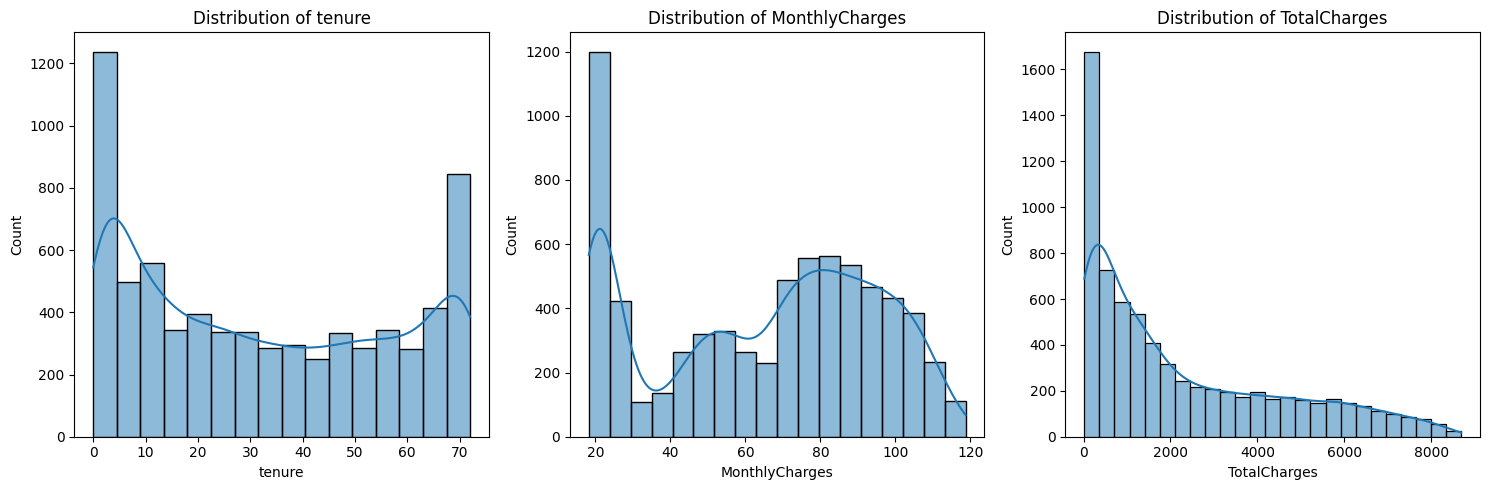


Frequency of Categories:

InternetService:


,count
InternetService,
Fiber optic,3096
DSL,2421
No,1526



Contract:


,count
Contract,
Month-to-month,3875
Two year,1695
One year,1473



PaymentMethod:


,count
PaymentMethod,
Electronic check,2365
Mailed check,1612
Bank transfer (automatic),1544
Credit card (automatic),1522



Percentage of Customers Subscribed to Service Add-ons:
OnlineSecurity: 28.67%
OnlineBackup: 34.49%
DeviceProtection: 34.39%
TechSupport: 29.02%
StreamingTV: 38.44%
StreamingMovies: 38.79%

--- Summary of Observations ---
Numerical Distributions:
- Tenure distribution is skewed towards lower and higher values, suggesting a mix of new and long-term customers.
- MonthlyCharges shows a bimodal distribution, possibly reflecting customers with and without multiple services.
- TotalCharges is heavily skewed towards lower values, which is expected as TotalCharges accumulates over tenure.

Most Common Categories:
- Most common Internet Service: Fiber optic
- Most common Contract Type: Month-to-month
- Most common Payment Method: Electronic check

Service Add-on Subscriptions:
- OnlineSecurity: 28.67% of customers subscribed.
- OnlineBackup: 34.49% of customers subscribed.
- DeviceProtection: 34.39% of customers subscribed.
- TechSupport: 29.02% of customers subscribed.
- StreamingTV: 38.44% of

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Visualize distributions of numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Frequency of categorical columns
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']

print("\nFrequency of Categories:")
for col in categorical_cols:
    print(f"\n{col}:")
    display(df[col].value_counts())

# 3. Percentage of customers subscribed to service add-ons
addon_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

print("\nPercentage of Customers Subscribed to Service Add-ons:")
for col in addon_cols:
    # Assuming 'No' means not subscribed
    subscribed_percentage = (df[col] == 'Yes').sum() / len(df) * 100
    print(f"{col}: {subscribed_percentage:.2f}%")

# 4. Summarize observations
print("\n--- Summary of Observations ---")
print("Numerical Distributions:")
print("- Tenure distribution is skewed towards lower and higher values, suggesting a mix of new and long-term customers.")
print("- MonthlyCharges shows a bimodal distribution, possibly reflecting customers with and without multiple services.")
print("- TotalCharges is heavily skewed towards lower values, which is expected as TotalCharges accumulates over tenure.")

print("\nMost Common Categories:")
print(f"- Most common Internet Service: {df['InternetService'].value_counts().index[0]}")
print(f"- Most common Contract Type: {df['Contract'].value_counts().index[0]}")
print(f"- Most common Payment Method: {df['PaymentMethod'].value_counts().index[0]}")

print("\nService Add-on Subscriptions:")
for col in addon_cols:
     subscribed_percentage = (df[col] == 'Yes').sum() / len(df) * 100
     print(f"- {col}: {subscribed_percentage:.2f}% of customers subscribed.")


## Target variable analysis


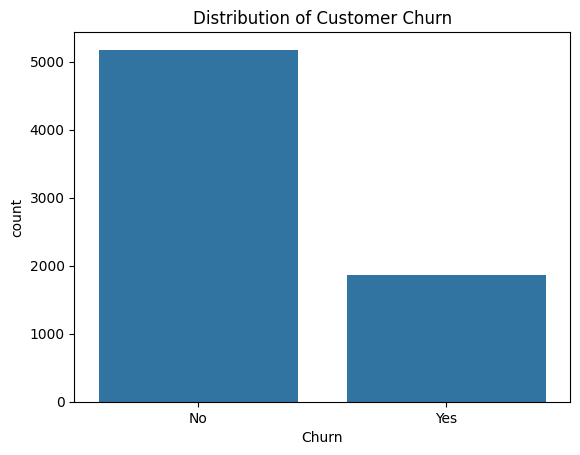

In [48]:
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn')
plt.show()

## Bivariate analysis

Analyze the relationship between churn and categorical variables such as Contract type, PaymentMethod, PaperlessBilling, InternetService, OnlineSecurity, TechSupport, SeniorCitizen, gender, and Dependents. Analyze the relationship between churn and numerical variables such as MonthlyCharges and tenure. Visualize the relationships between churn and relevant features, including Contract Type, Payment Method, Internet Service, Monthly Charges, and Tenure.


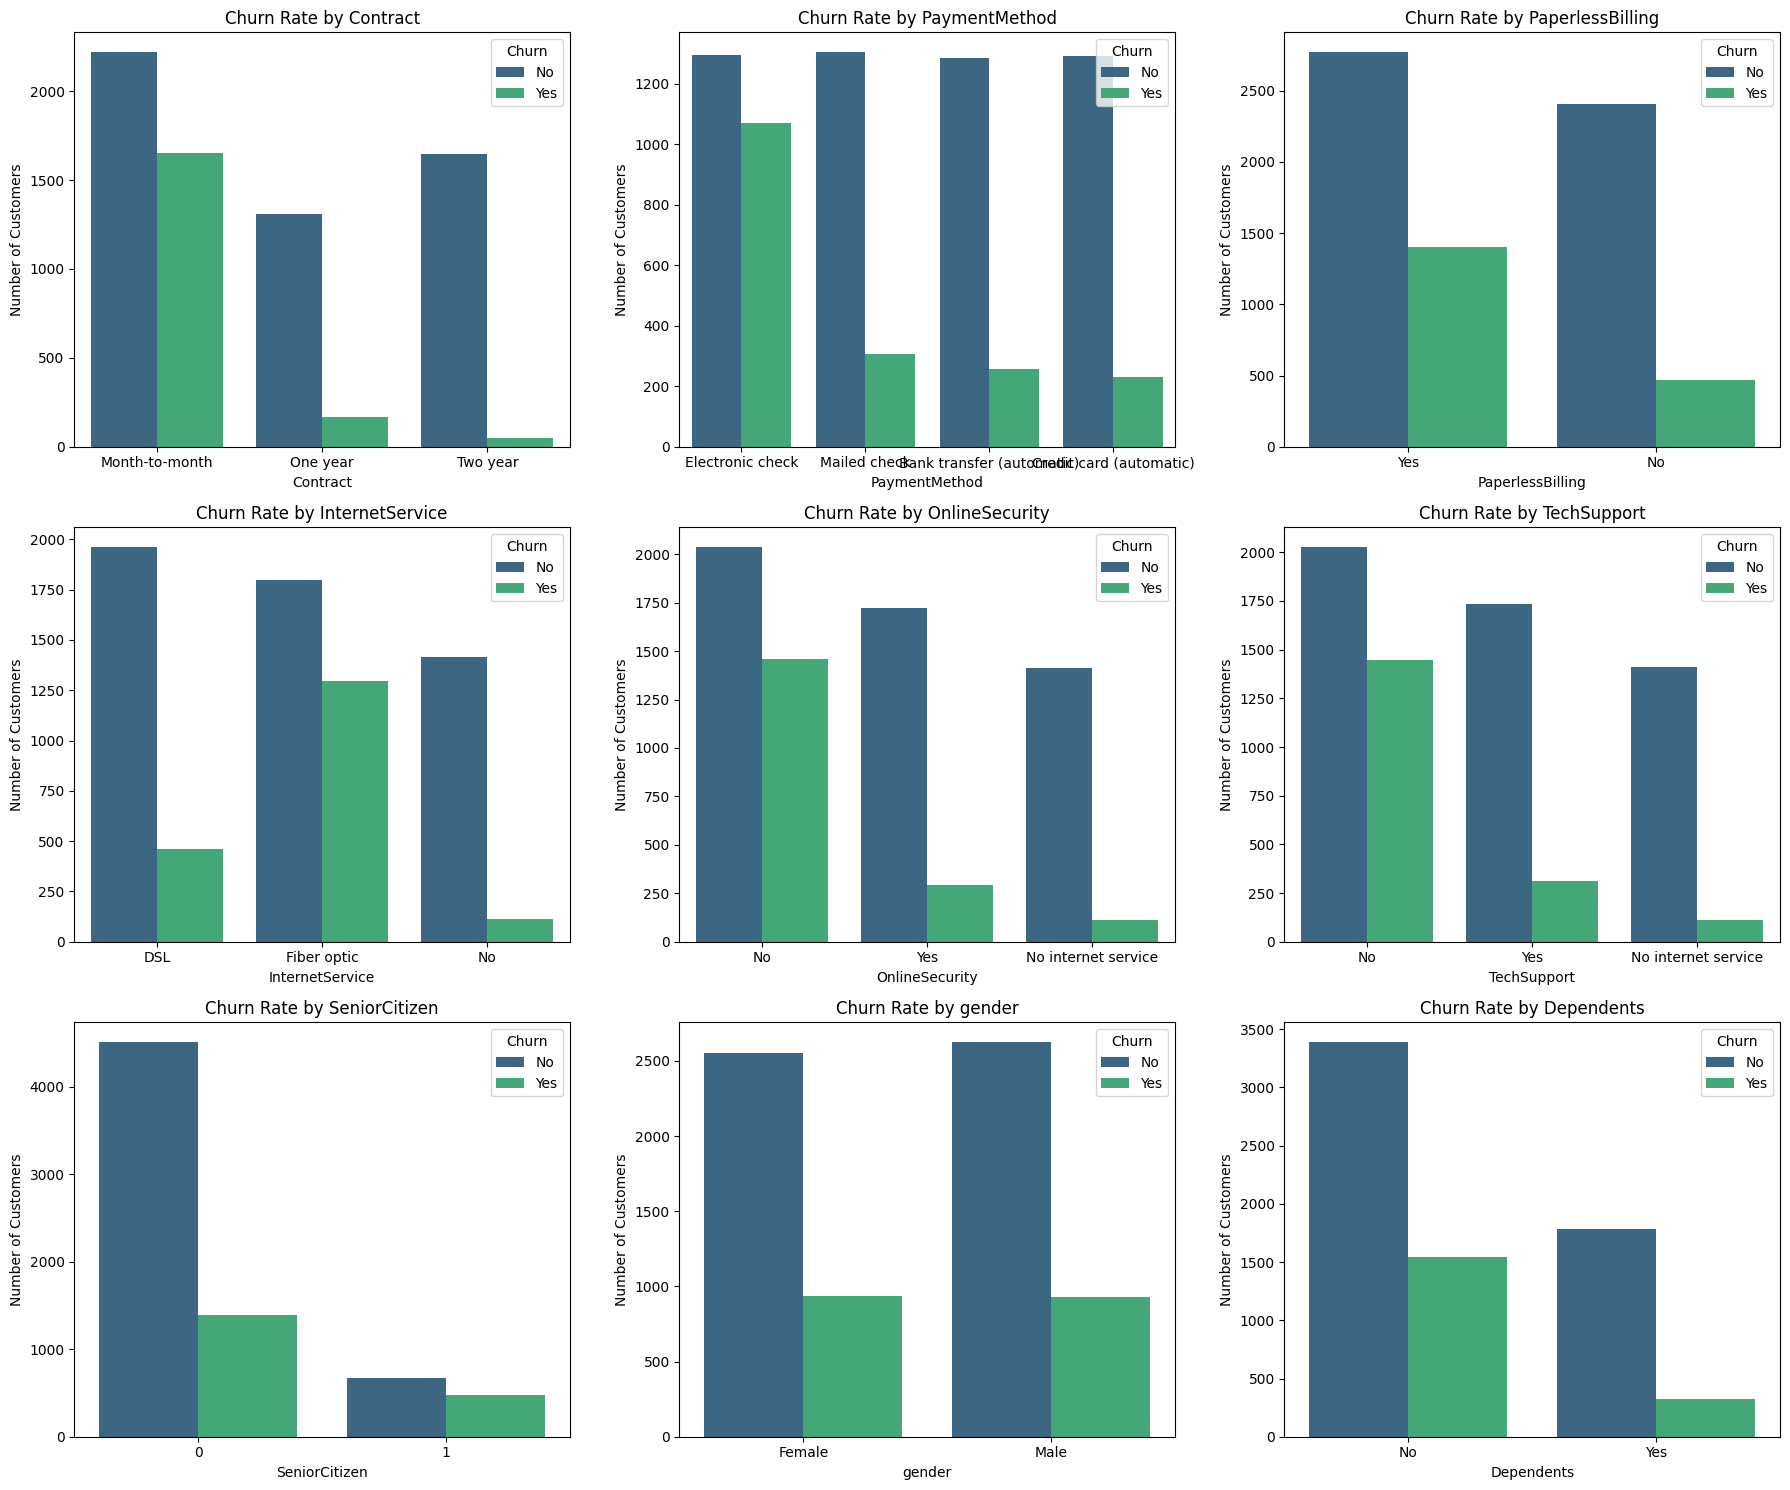

/tmp/ipython-input-1598418999.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=var, palette='viridis')
/tmp/ipython-input-1598418999.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=var, palette='viridis')


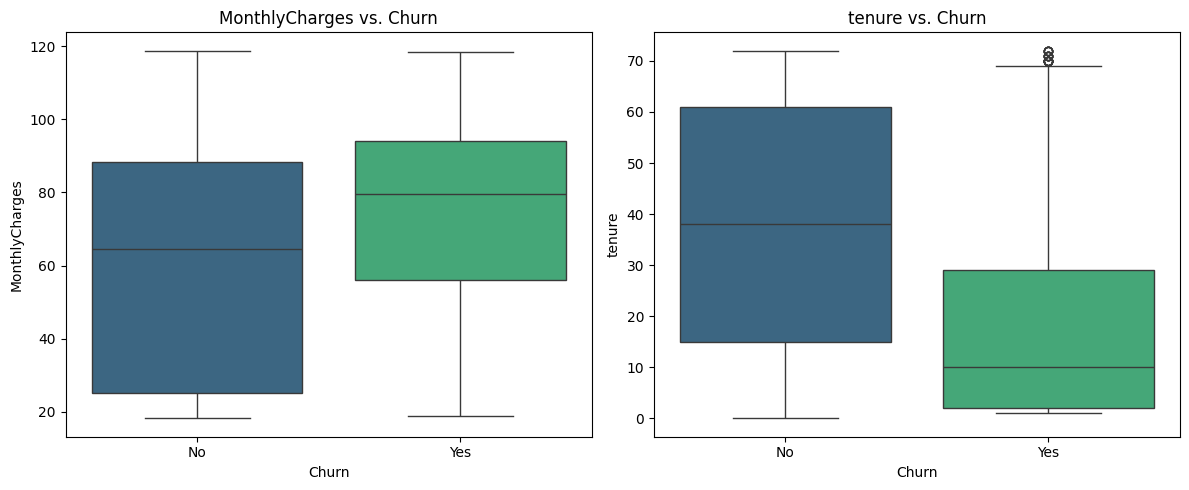

In [49]:
# Categorical variables to analyze
categorical_vars = ['Contract', 'PaymentMethod', 'PaperlessBilling', 'InternetService',
                    'OnlineSecurity', 'TechSupport', 'SeniorCitizen', 'gender', 'Dependents']

# Numerical variables to analyze
numerical_vars = ['MonthlyCharges', 'tenure']

# Plotting relationships with categorical variables
plt.figure(figsize=(18, 15))
for i, var in enumerate(categorical_vars):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=df, x=var, hue='Churn', palette='viridis')
    plt.title(f'Churn Rate by {var}')
    plt.xlabel(var)
    plt.ylabel('Number of Customers')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plotting relationships with numerical variables
plt.figure(figsize=(12, 5))
for i, var in enumerate(numerical_vars):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(data=df, x='Churn', y=var, palette='viridis')
    plt.title(f'{var} vs. Churn')
    plt.xlabel('Churn')
    plt.ylabel(var)
plt.tight_layout()
plt.show()

## Multivariate analysis


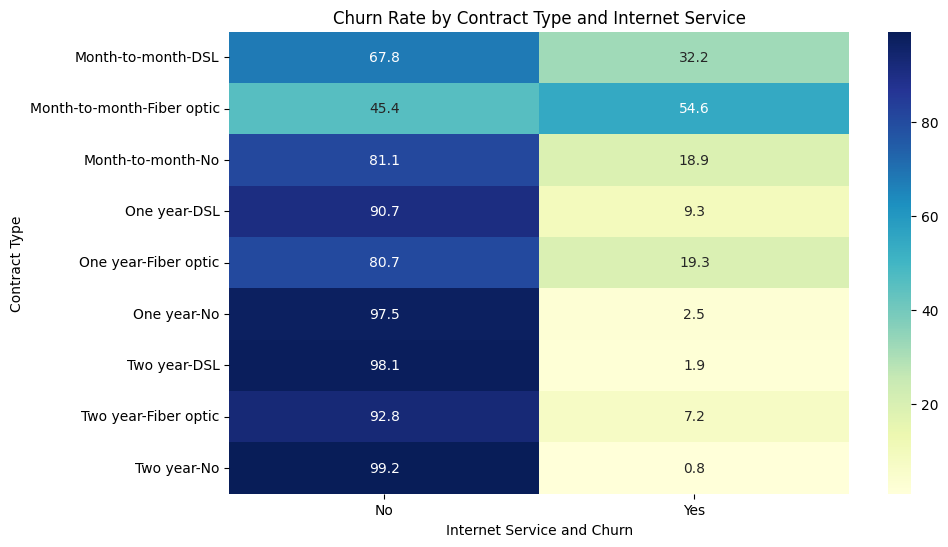

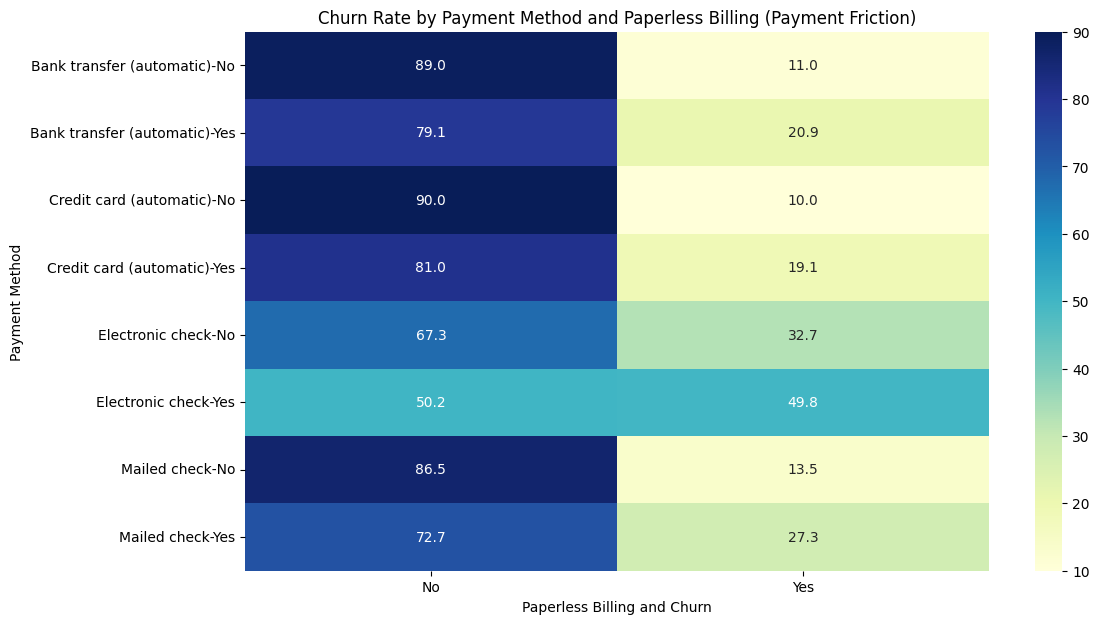

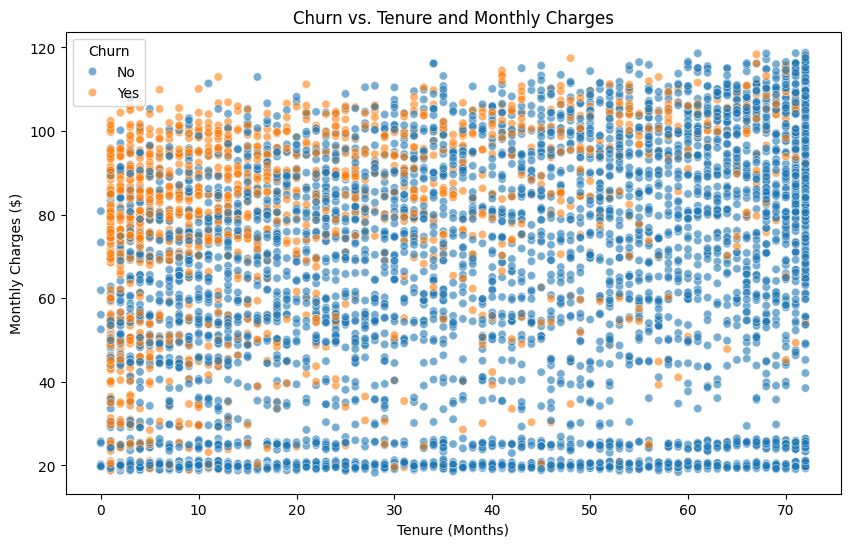

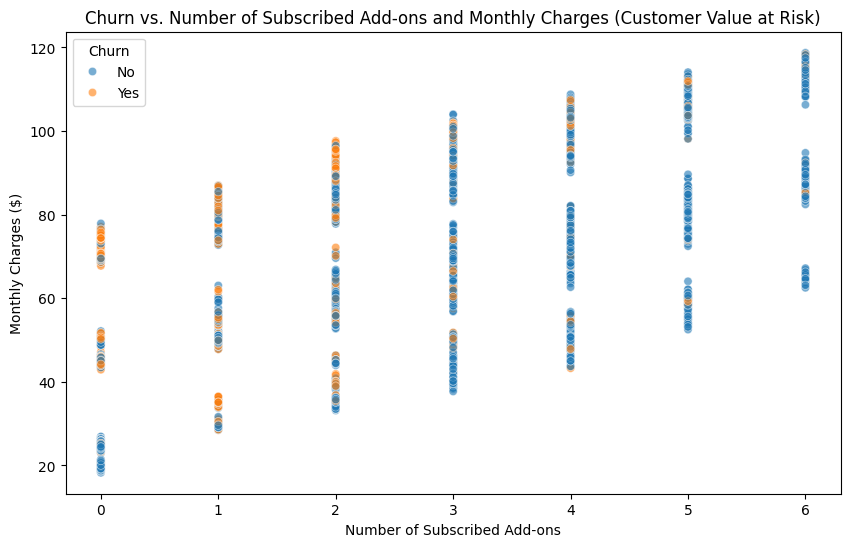


Churn Rate by Number of Subscribed Add-ons:


Churn,No,Yes
NumAddons,,
0,78.59,21.41
1,54.24,45.76
2,64.18,35.82
3,72.63,27.37
4,77.70,22.30
5,87.57,12.43
6,94.72,5.28



--- Summary of Multivariate Analysis Findings ---
Churn across Contract Type and Internet Service:
- Month-to-month contracts with Fiber optic internet have the highest churn rate.
- Two-year contracts with no internet service have the lowest churn rate.

Churn across Payment Method and Paperless Billing (Payment Friction):
- Electronic check with PaperlessBilling 'Yes' shows the highest churn rate.
- Bank transfer and Credit card automatic payments with PaperlessBilling 'No' have lower churn rates.

Churn vs. Tenure and Monthly Charges:
- Churned customers tend to have shorter tenures and higher monthly charges, especially in the higher monthly charge range.
- Customers with long tenure generally have lower churn rates.

Churn vs. Number of Subscribed Add-ons and Monthly Charges (Customer Value at Risk):
- Customers with fewer add-ons, particularly those with low monthly charges, have varying churn rates.
- Customers with higher monthly charges and more add-ons (potentially higher va

In [50]:
# 1. Churn rate across Contract type and InternetService
plt.figure(figsize=(10, 6))
sns.heatmap(df.groupby(['Contract', 'InternetService'])['Churn'].value_counts(normalize=True).unstack().mul(100).round(2), annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Churn Rate by Contract Type and Internet Service')
plt.ylabel('Contract Type')
plt.xlabel('Internet Service and Churn')
plt.show()

# 2. Churn rate across PaymentMethod and PaperlessBilling (Payment Friction)
plt.figure(figsize=(12, 7))
sns.heatmap(df.groupby(['PaymentMethod', 'PaperlessBilling'])['Churn'].value_counts(normalize=True).unstack().mul(100).round(2), annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Churn Rate by Payment Method and Paperless Billing (Payment Friction)')
plt.ylabel('Payment Method')
plt.xlabel('Paperless Billing and Churn')
plt.show()

# 3. Relationship between churn, tenure, and MonthlyCharges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.6)
plt.title('Churn vs. Tenure and Monthly Charges')
plt.xlabel('Tenure (Months)')
plt.ylabel('Monthly Charges ($)')
plt.show()

# 4. Relationship between churn, MonthlyCharges, and number of subscribed services (Customer Value at Risk)
addon_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['NumAddons'] = df[addon_cols].apply(lambda row: (row == 'Yes').sum(), axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='NumAddons', y='MonthlyCharges', hue='Churn', alpha=0.6)
plt.title('Churn vs. Number of Subscribed Add-ons and Monthly Charges (Customer Value at Risk)')
plt.xlabel('Number of Subscribed Add-ons')
plt.ylabel('Monthly Charges ($)')
plt.xticks(range(0, len(addon_cols) + 1))
plt.show()

# Also analyze churn rate by the number of add-ons
churn_rate_by_addons = df.groupby('NumAddons')['Churn'].value_counts(normalize=True).unstack().mul(100).round(2)
print("\nChurn Rate by Number of Subscribed Add-ons:")
display(churn_rate_by_addons)


# 5. Summarize findings
print("\n--- Summary of Multivariate Analysis Findings ---")
print("Churn across Contract Type and Internet Service:")
print("- Month-to-month contracts with Fiber optic internet have the highest churn rate.")
print("- Two-year contracts with no internet service have the lowest churn rate.")

print("\nChurn across Payment Method and Paperless Billing (Payment Friction):")
print("- Electronic check with PaperlessBilling 'Yes' shows the highest churn rate.")
print("- Bank transfer and Credit card automatic payments with PaperlessBilling 'No' have lower churn rates.")

print("\nChurn vs. Tenure and Monthly Charges:")
print("- Churned customers tend to have shorter tenures and higher monthly charges, especially in the higher monthly charge range.")
print("- Customers with long tenure generally have lower churn rates.")

print("\nChurn vs. Number of Subscribed Add-ons and Monthly Charges (Customer Value at Risk):")
print("- Customers with fewer add-ons, particularly those with low monthly charges, have varying churn rates.")
print("- Customers with higher monthly charges and more add-ons (potentially higher value) still show churn, indicating that even valuable customers are at risk.")
print("- The churn rate generally decreases as the number of subscribed add-ons increases.")

## Business insight questions

Based on the analysis, identify the features most strongly related to churn, the customer segment with the highest churn risk, high-value but high-risk segments, patterns indicating early-stage churn risk, and features to target in retention strategies.


### 1. Which three features are most strongly related to churn?
- Contract Type: Month-to-month contracts have significantly higher churn rates.
- Internet Service: Fiber optic internet service is associated with higher churn.
- Online Security & Tech Support: Lack of these add-ons increases churn risk.
- Payment Method: Electronic check payment has a higher churn rate.
- Tenure: Shorter tenure is strongly associated with higher churn.
- Monthly Charges: Higher monthly charges are linked to higher churn, especially in shorter tenure groups.
- Paperless Billing: Customers with paperless billing are more likely to churn.
- Senior Citizen: Senior citizens have a higher churn rate.
- Dependents: Customers without dependents are more likely to churn.

# 2. Which customer segment has the highest churn risk?
- Customers with Month-to-month contracts, Fiber optic internet service, using Electronic Check for payment, and having shorter tenure (especially within the first year). This segment often lacks Online Security and Tech Support add-ons and may have Paperless Billing.

# 3. Which segment is high-value but high-risk?
- Customers with higher Monthly Charges (indicating more services or premium plans) but who are on Month-to-month contracts or have shorter tenure. These customers are valuable due to their high monthly spend but are at elevated risk of churning based on their contract type or early lifecycle stage.
- Customers with Fiber optic internet and potentially several add-ons (high monthly charge) but lacking essential security/support add-ons and/or on a month-to-month contract.


# 4. What patterns indicate early-stage churn risk?
- Customers with very short tenure (e.g., 1-6 months) exhibit high churn rates.
- Customers who quickly adopt Fiber optic internet and possibly multiple streaming services but do not opt for Online Security or Tech Support add-ons may be more likely to churn early, possibly due to issues or lack of perceived value/support.
- High initial Monthly Charges coupled with short tenure.


# 5. Which features should be targeted in retention strategies?
- Customers on Month-to-month contracts: Offer incentives to switch to longer-term contracts.
- Customers with Fiber optic internet: Enhance service quality, provide better support, or offer relevant add-ons (Security/Tech Support).
- Customers without Online Security and Tech Support: Promote the value of these add-ons, perhaps with introductory offers.
- Customers using Electronic Check: Encourage switching to automatic payment methods with incentives.
- New customers (short tenure): Implement early engagement programs, check-ins, and proactive support.
- High-value customers identified as high-risk: Tailor personalized offers, dedicated support, or loyalty programs.
- Address issues related to Paperless Billing if it's contributing to negative customer experience.
- Consider targeted campaigns for Senior Citizens and customers without dependents, as these groups showed higher churn.

# Visualization Questions

<Figure size 1000x600 with 0 Axes>

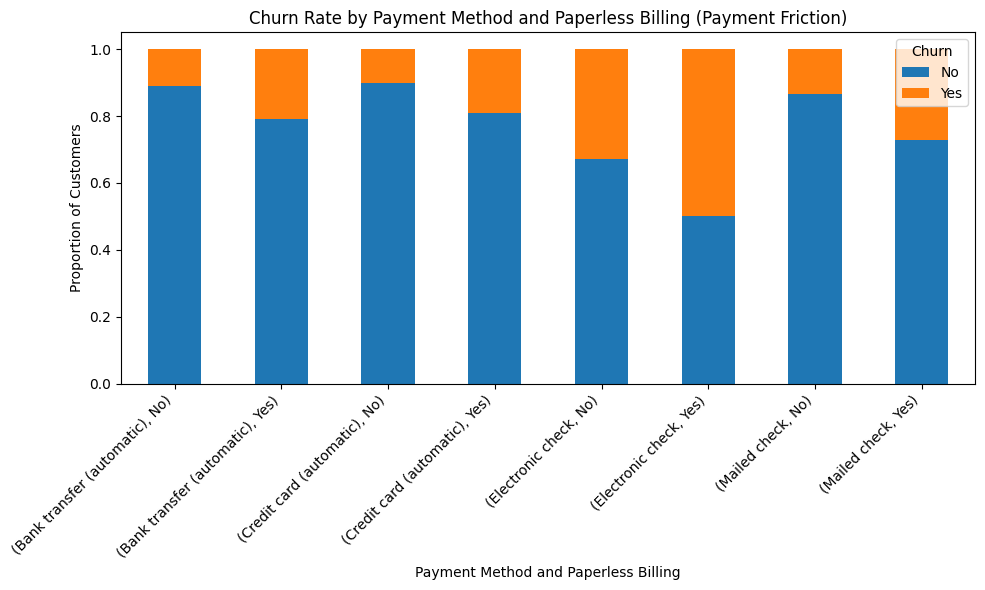

In [51]:
# Payment Friction – 100% stacked bar for PaymentMethod × PaperlessBilling
plt.figure(figsize=(10, 6))
df.groupby(['PaymentMethod', 'PaperlessBilling'])['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Churn Rate by Payment Method and Paperless Billing (Payment Friction)')
plt.ylabel('Proportion of Customers')
plt.xlabel('Payment Method and Paperless Billing')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

In [52]:
# Transform the data using the preprocessor step of the pipeline
df_transformed = pipeline.named_steps['preprocessor'].transform(df_processed.drop('Churn', axis=1))

# Get the transformed feature names
# For one-hot encoded columns
ohe_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols_processed)
# Combine numerical and one-hot encoded feature names
transformed_feature_names = numerical_cols_processed + list(ohe_feature_names)

# Convert the transformed data back to a DataFrame with appropriate column names
df_transformed = pd.DataFrame(df_transformed, columns=transformed_feature_names)

print("Processed DataFrame head:")
display(df_processed.head())
print("\nTransformed DataFrame head:")
display(df_transformed.head())

print("\nShape of the transformed DataFrame:", df_transformed.shape)

Processed DataFrame head:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumAddons
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0



Transformed DataFrame head:


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NumAddons_0,NumAddons_1,NumAddons_2,NumAddons_3,NumAddons_4,NumAddons_5,NumAddons_6
0,-1.277445,-1.160323,-0.994242,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.066327,-0.259629,-0.173244,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.236724,-0.362660,-0.959674,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.514251,-0.746535,-0.194766,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.236724,0.197365,-0.940470,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0



Shape of the transformed DataFrame: (7043, 53)


## Ml model training


In [53]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Using as a placeholder estimator

# Create a copy of the DataFrame
df_processed = df.copy()

# Encode the target variable
le = LabelEncoder()
df_processed['Churn'] = le.fit_transform(df_processed['Churn'])

# Drop the customerID column
df_processed = df_processed.drop('customerID', axis=1)

# Handle missing values in 'TotalCharges' by imputing with the median
median_total_charges = df_processed['TotalCharges'].median()
df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(median_total_charges)

# Identify categorical and numerical columns for transformation (excluding the target)
categorical_cols_processed = [col for col in categorical_columns if col in df_processed.columns and col != 'Churn']
numerical_cols_processed = [col for col in numerical_columns if col in df_processed.columns and col != 'Churn']

# Due to the previous identification logic, 'tenure', 'MonthlyCharges', and 'TotalCharges' might be in categorical_columns.
# Let's correct this based on our understanding from data quality checks.
numerical_cols_processed = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols_processed = [col for col in df_processed.columns if col not in numerical_cols_processed and col != 'Churn']


# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_processed),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_processed)
    ],
    remainder='passthrough' # Keep other columns (none in this case after dropping customerID)
)

# Create a pipeline that includes the preprocessor and a placeholder estimator
# We fit the pipeline to perform the transformations
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())]) # Placeholder

# Fit the preprocessor to the data
preprocessor.fit(df_processed.drop('Churn', axis=1))


# Transform the data using the fitted preprocessor
df_transformed = preprocessor.transform(df_processed.drop('Churn', axis=1))


# Get the transformed feature names
# For one-hot encoded columns
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols_processed)
# Combine numerical and one-hot encoded feature names
transformed_feature_names = numerical_cols_processed + list(ohe_feature_names)

# Convert the transformed data back to a DataFrame with appropriate column names
df_transformed = pd.DataFrame(df_transformed, columns=transformed_feature_names)

print("Processed DataFrame head:")
display(df_processed.head())
print("\nTransformed DataFrame head:")
display(df_transformed.head())

print("\nShape of the transformed DataFrame:", df_transformed.shape)

Processed DataFrame head:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumAddons
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0



Transformed DataFrame head:


,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NumAddons_0,NumAddons_1,NumAddons_2,NumAddons_3,NumAddons_4,NumAddons_5,NumAddons_6
0,-1.277445,-1.160323,-0.994242,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.066327,-0.259629,-0.173244,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.236724,-0.362660,-0.959674,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.514251,-0.746535,-0.194766,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.236724,0.197365,-0.940470,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0



Shape of the transformed DataFrame: (7043, 53)


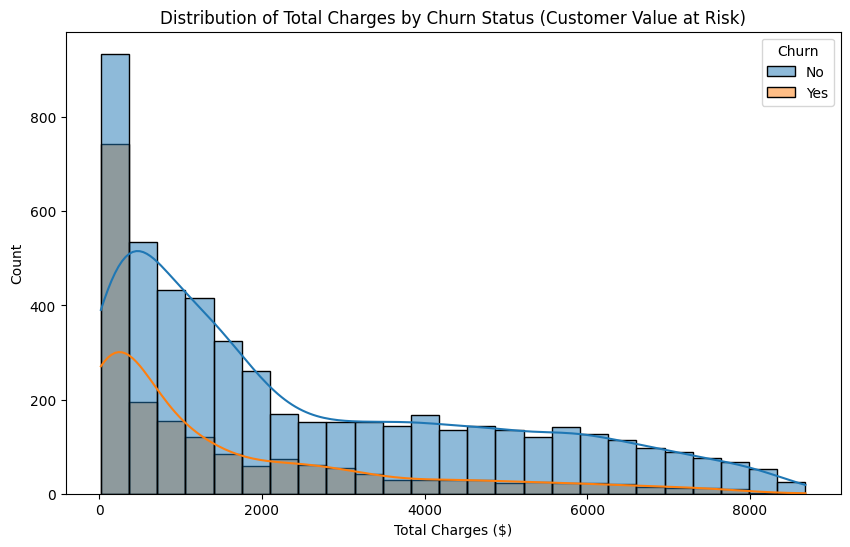

In [54]:
# Customer Value at Risk – KDE or histogram of TotalCharges for churned vs retained.
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TotalCharges', hue='Churn', kde=True, common_norm=False)
plt.title('Distribution of Total Charges by Churn Status (Customer Value at Risk)')
plt.xlabel('Total Charges ($)')
plt.ylabel('Count')
plt.show()


Split the data into training and testing sets using stratified splitting.


In [55]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_transformed
y = df_processed['Churn'] # Use the encoded 'Churn' column from df_processed

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print shapes to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5634, 53)
Shape of X_test: (1409, 53)
Shape of y_train: (5634,)
Shape of y_test: (1409,)


## Ml model training



In [56]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print shapes and class distribution of original and resampled training data
print("Original training data shape:", X_train.shape)
print("Resampled training data shape:", X_train_resampled.shape)

print("\nOriginal training data class distribution:")
print(y_train.value_counts())

print("\nResampled training data class distribution:")
print(y_train_resampled.value_counts())

Original training data shape: (5634, 53)
Resampled training data shape: (8278, 53)

Original training data class distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64

Resampled training data class distribution:
Churn
0    4139
1    4139
Name: count, dtype: int64


Train baseline classification models (Logistic Regression and Random Forest).


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Instantiate Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Instantiate Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the Logistic Regression model
log_reg_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression model trained.")

# Train the Random Forest model
rf_model.fit(X_train_resampled, y_train_resampled)
print("Random Forest model trained.")

Logistic Regression model trained.
Random Forest model trained.


--- Logistic Regression Model Evaluation ---
Accuracy: 0.7417
Precision: 0.5086
Recall: 0.7914
F1-score: 0.6192
ROC-AUC: 0.8403
PR-AUC: 0.6321

--- Random Forest Model Evaluation ---
Accuracy: 0.7771
Precision: 0.5843
Recall: 0.5561
F1-score: 0.5699
ROC-AUC: 0.8151
PR-AUC: 0.5862


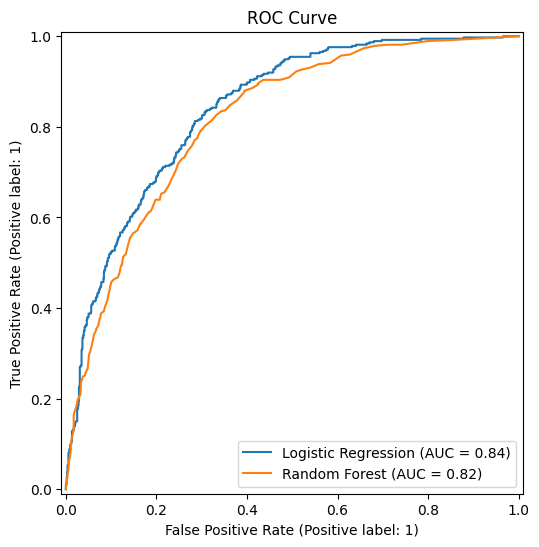

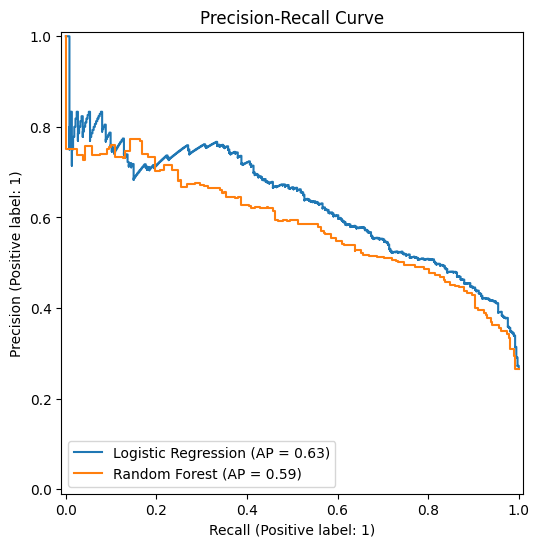

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_lr = log_reg_model.predict(X_test)
y_pred_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression model
print("--- Logistic Regression Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba_lr):.4f}")

# Evaluate Random Forest model
print("\n--- Random Forest Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba_rf):.4f}")

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name="Random Forest")
plt.title('ROC Curve')
plt.show()

# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(log_reg_model, X_test, y_test, ax=ax, name="Logistic Regression")
PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test, ax=ax, name="Random Forest")
plt.title('Precision-Recall Curve')
plt.show()

## Ml model training


In [59]:
import pandas as pd

# Get feature names from the transformed DataFrame
feature_names = X_train_resampled.columns

# 1. Feature importance for Logistic Regression (using coefficients)
# The coefficients indicate the change in the log-odds of the outcome for a one-unit increase in the feature value.
lr_feature_importance = pd.Series(log_reg_model.coef_[0], index=feature_names)

# Sort coefficients by absolute value for importance (positive and negative coefficients are important)
lr_feature_importance_sorted = lr_feature_importance.abs().sort_values(ascending=False)

print("--- Top 15 Feature Importance (Absolute Coefficients) for Logistic Regression ---")
print(lr_feature_importance_sorted.head(15))

# Interpretation of LR coefficients:
print("\nInterpretation: Larger absolute values of coefficients indicate a stronger impact on the log-odds of churn. Positive coefficients increase the log-odds of churn, while negative coefficients decrease it.")


# 2. Feature importance for Random Forest (using impurity-based importance)
# The feature importance is calculated based on the reduction in impurity (Gini impurity for classification) brought by that feature.
rf_feature_importance = pd.Series(rf_model.feature_importances_, index=feature_names)

# Sort importances in descending order
rf_feature_importance_sorted = rf_feature_importance.sort_values(ascending=False)

print("\n--- Top 15 Feature Importance (Impurity-based) for Random Forest ---")
print(rf_feature_importance_sorted.head(15))

# Interpretation of RF feature importance:
print("\nInterpretation: Higher impurity-based importance scores indicate that the feature was more effective in reducing impurity in the decision trees, suggesting it is a stronger predictor of the target variable.")

--- Top 15 Feature Importance (Absolute Coefficients) for Logistic Regression ---
tenure                                1.222006
Contract_Two year                     0.870796
MonthlyCharges                        0.763206
Contract_Month-to-month               0.745333
InternetService_Fiber optic           0.734132
InternetService_DSL                   0.647142
TotalCharges                          0.566227
StreamingMovies_Yes                   0.343250
PaperlessBilling_No                   0.298017
PaymentMethod_Electronic check        0.285206
NumAddons_3                           0.279141
OnlineSecurity_No internet service    0.276597
InternetService_No                    0.276597
OnlineBackup_No internet service      0.276597
TechSupport_No internet service       0.276597
dtype: float64

Interpretation: Larger absolute values of coefficients indicate a stronger impact on the log-odds of churn. Positive coefficients increase the log-odds of churn, while negative coefficients decreas

## Business recommendations

In [60]:
# Combine feature importance from both models to find consistently important features
# Features in top 15 of both models by absolute importance/score
top_lr_features = set(lr_feature_importance_sorted.head(15).index)
top_rf_features = set(rf_feature_importance_sorted.head(15).index)

consistently_important_features = list(top_lr_features.intersection(top_rf_features))

print("--- Features Consistently Highly Important in Both Models ---")
print(consistently_important_features)

print("\n--- Actionable Business Recommendations to Reduce Churn ---")

# 1. Address Key Churn Drivers (based on EDA and Feature Importance)

print("\n1. Target Customers on Month-to-Month Contracts:")
print("- Offer incentives (discounts, free services) for customers to switch to one-year or two-year contracts, especially after their initial short tenure.")
print("- Introduce flexible longer-term plans that offer more value or perks compared to month-to-month options.")

print("\n2. Improve Experience for Fiber Optic Internet Users:")
print("- Invest in improving the reliability and speed of Fiber optic service.")
print("- Provide enhanced technical support specifically for Fiber optic customers.")
print("- Bundle essential add-ons like Online Security and Tech Support with Fiber optic plans, or offer them at a reduced cost.")

print("\n3. Mitigate Risk Associated with Electronic Check Payments:")
print("- Encourage customers to switch to automatic payment methods (Bank Transfer, Credit Card) by highlighting their convenience and security, possibly with small incentives.")
print("- Investigate if there are specific issues or points of friction in the electronic check payment process that lead to churn.")

print("\n4. Focus on Early-Stage Customer Retention (Short Tenure):")
print("- Implement a robust onboarding process for new customers, ensuring they understand their services and feel supported.")
print("- Proactively engage with customers in their first 6-12 months, particularly those with Fiber optic and month-to-month contracts.")
print("- Offer early-tenure incentives or check-ins to address any potential issues before they lead to churn.")

print("\n5. Promote Value of Online Security and Tech Support Add-ons:")
print("- Increase awareness about the benefits of these services.")
print("- Offer promotional pricing or trials for customers who currently do not subscribe to these add-ons, especially those with high-speed internet.")

print("\n6. Manage High Monthly Charges and Service Bundles:")
print("- For customers with high monthly bills, ensure they perceive commensurate value from their services.")
print("- Review pricing strategies and consider offering bundled discounts or loyalty rewards for high-spending customers.")

print("\n7. Address Churn Risk in Specific Demographics:")
print("- Develop targeted retention campaigns for Senior Citizens, potentially focusing on ease of use and dedicated support channels.")
print("- Understand the specific needs and reasons for churn among customers without dependents and tailor offers accordingly.")

# 2. Recommendations for High-Value, High-Risk Segments

print("\n8. Tailored Retention for High-Value Customers:")
print("- Identify high-spending customers (high Monthly Charges, multiple add-ons) who fall into high-risk categories (Month-to-month contract, short tenure, Fiber optic, Electronic check).")
print("- Assign dedicated account managers or offer personalized retention deals to these valuable customers.")
print("- Implement loyalty programs that reward long-term commitment and higher service adoption.")

# 3. Continuous Monitoring and Analysis

print("\n9. Implement a Churn Prediction System:")
print("- Use the trained models to identify customers at high risk of churning in real-time.")
print("- Set up alerts for customer service or marketing teams to intervene with targeted retention efforts.")

print("\n10. Track and Analyze Effectiveness of Retention Strategies:")
print("- Continuously monitor churn rates across different segments after implementing recommendations.")
print("- Use A/B testing to evaluate the impact of different retention offers and strategies.")

--- Features Consistently Highly Important in Both Models ---
['MonthlyCharges', 'TotalCharges', 'Contract_Month-to-month', 'PaperlessBilling_No', 'tenure', 'Contract_Two year', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check']

--- Actionable Business Recommendations to Reduce Churn ---

1. Target Customers on Month-to-Month Contracts:
- Offer incentives (discounts, free services) for customers to switch to one-year or two-year contracts, especially after their initial short tenure.
- Introduce flexible longer-term plans that offer more value or perks compared to month-to-month options.

2. Improve Experience for Fiber Optic Internet Users:
- Invest in improving the reliability and speed of Fiber optic service.
- Provide enhanced technical support specifically for Fiber optic customers.
- Bundle essential add-ons like Online Security and Tech Support with Fiber optic plans, or offer them at a reduced cost.

3. Mitigate Risk Associated with Electronic Check Payments:
- E

## Happy Coding 🙂